In [38]:
#imports
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import datasets, transforms
import pandas as pd
import spacy
from torch.nn.utils.rnn import pad_sequence
from matplotlib import pyplot as plt
from PIL import Image
import os
import torchvision.models as models

In [40]:
new_model = models.inception_v3(pretrained=True, aux_logits=True)
new_model.fc

c:\Users\britta\anaconda3\envs\nnlm\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\britta\anaconda3\envs\nnlm\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\britta/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:02<00:00, 44.8MB/s] 


Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
spacy_eng = spacy.load("en_core_web_sm")

In [17]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [18]:
annotation = pd.read_csv("../data/flickr8kimagescaptions/captions.txt")
annotation.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [19]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [20]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="../data/flickr8kimagescaptions/Images", caption_path="../data/flickr8kimagescaptions/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pd.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [21]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [22]:
# transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [25]:
def get_loader(root_dir="../data/flickr8kimagescaptions/images", caption_path="../data/flickr8kimagescaptions/captions.txt", transform=transform, batch_size=32, num_workers=2, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [27]:
loader, dataset = get_loader()

10000


In [31]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108926, 108200, 108663, 108917, 108613, 108624, 108929, 108890,
        108627, 108919, 107172, 108926, 105232, 108925,      2])
<SOS> a white dog is jumping up in the air to catch a frisbee . <EOS> 

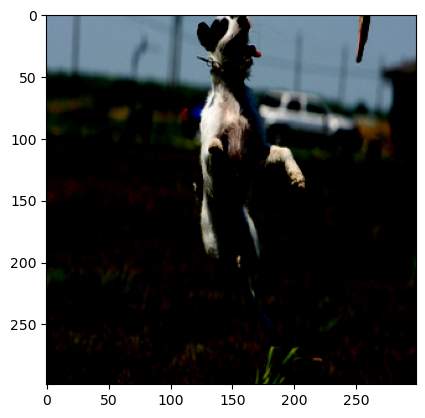

In [32]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [33]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [34]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [35]:
from tqdm import tqdm
# from torchvision.utils.tensorboard import SummaryWriter

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [4]:
# get dataset
# Define the mini-batch size
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor()
])

# Download the dataset and create the dataloaders
flickr_data = datasets.Flickr8k("./", transform=transform)

print(len(flickr_data))

train_size = int(0.8 * len(flickr_data))
val_size = len(flickr_data)-train_size

flickr_train, flickr_val = torch.utils.data.random_split(flickr_data, [train_size, val_size])

train_loader = DataLoader(flickr_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(flickr_val, batch_size=batch_size, shuffle=False)

TypeError: __init__() missing 1 required positional argument: 'ann_file'

In [ ]:
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        
        resnet = torchvision.models.resnet101(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.imageNetwork = nn.Sequential(
            # TODO input size
            nn.Linear(128,256),
            nn.ReLU()
        )

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  
        out  = out.view(out.size(0), -1)
        out = self.imageNetwork(out)
        return out

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.

        :param fine_tune: Allow?
        """
        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        return x[:, -1, :]  # Get the output of the last time step

In [ ]:
class DecoderWithAttention(nn.Module):
    """
    Decoder.
    """

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)  # attention network

        self.embedding = nn.Embedding(vocab_size, embed_dim)  # embedding layer
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        """
        Loads embedding layer with pre-trained embeddings.

        :param embeddings: pre-trained embeddings
        """
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        """
        Allow fine-tuning of embedding layer? (Only makes sense to not-allow if using pre-trained embeddings).

        :param fine_tune: Allow?
        """
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :return: hidden state, cell state
        """
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        Forward propagation.

        :param encoder_out: encoded images, a tensor of dimension (batch_size, enc_image_size, enc_image_size, encoder_dim)
        :param encoded_captions: encoded captions, a tensor of dimension (batch_size, max_caption_length)
        :param caption_lengths: caption lengths, a tensor of dimension (batch_size, 1)
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights, sort indices
        """

        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind